In [44]:
# Importing necessary libraries
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer
from matplotlib import pyplot as plt

In [100]:
#Load dataset
df = pd.read_csv("C:/Users/namya_rpahcdl/Documents/ratings.csv")
df = df.drop(columns=['timestamp'])
# Checking dataset
print('Shape:',df.shape, '\n')
print('Max values in dataset \n',df.max(), '\n')
print('Min values in dataset \n',df.min(), '\n')
# Filtering data for only 4+ ratings, high ratings = liking a movie
df = df[df['rating'] >= 4.0]
print('Shape: ',df.shape, '\n')
print('Max values in dataset \n',df.max(), '\n')
print('Min values in dataset \n',df.min(), '\n')

Shape: (26024289, 3) 

Max values in dataset 
 userId     270896.0
movieId    176275.0
rating          5.0
dtype: float64 

Min values in dataset 
 userId     1.0
movieId    1.0
rating     0.5
dtype: float64 

Shape:  (12981742, 3) 

Max values in dataset 
 userId     270896.0
movieId    176271.0
rating          5.0
dtype: float64 

Min values in dataset 
 userId     1.0
movieId    1.0
rating     4.0
dtype: float64 



In [46]:
#filtering ratings for 10000 users
users_list = np.unique(df['userId'])[:10000]
df = df.loc[df['userId'].isin(users_list)]
print('Shape: ',df.shape, '\n')
print('Max values in dataset',df.max(), '\n')
print('Min values in dataset',df.min(), '\n')
print('Total of Users: ', np.unique(df['userId']).shape[0])
print('Total Movies which are rated by users: ', np.unique(df['movieId']).shape[0])

Shape:  (498867, 3) 

Max values in dataset userId      10219.0
movieId    176271.0
rating          5.0
dtype: float64 

Min values in dataset userId     1.0
movieId    1.0
rating     4.0
dtype: float64 

Total Users:  10000
Total Movies which are rated by users:  13412


In [47]:
df.T

,1,2,3,4,5,6,7,8,9,10,...,1003289,1003292,1003297,1003299,1003300,1003301,1003303,1003304,1003305,1003306
userId,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,10218.0,10218.0,10218.0,10218.0,10219.0,10219.0,10219.0,10219.0,10219.0,10219.0
movieId,147.0,858.0,1221.0,1246.0,1968.0,2762.0,2918.0,2959.0,4226.0,4878.0,...,7153.0,8961.0,40815.0,49272.0,480.0,593.0,858.0,912.0,1381.0,3752.0
rating,4.5,5.0,5.0,5.0,4.0,4.5,5.0,4.0,4.0,5.0,...,4.0,4.0,4.0,5.0,4.0,4.0,5.0,5.0,5.0,5.0


In [49]:
filtered_ratings = df.to_csv("C:/Users/namya_rpahcdl/Documents/filtered_ratings_v3.csv")

In [51]:
data = pd.read_csv("C:/Users/namya_rpahcdl/Documents/filtered_ratings_v3.csv", index_col=0)

# Display the first few rows
print(data.head())

   userId  movieId  rating
1       1      147     4.5
2       1      858     5.0
3       1     1221     5.0
4       1     1246     5.0
5       1     1968     4.0


In [52]:
# data = data.drop(columns=['Unnamed: 0'])
# Check for missing values
print("Missing values:\n", data.isnull().sum())

# Check for duplicate entries
print("Duplicate rows:", data.duplicated().sum())

# Drop duplicates and missing values if found
data = data.drop_duplicates()
data = data.dropna()

Missing values:
 userId     0
movieId    0
rating     0
dtype: int64
Duplicate rows: 0


In [53]:
# Create a pivot table
user_item_matrix = data.pivot(index='userId', columns='movieId', values='rating').fillna(0)

# Convert the matrix to a NumPy array for clustering
X = user_item_matrix.values

In [54]:
print(data.columns)

Index(['userId', 'movieId', 'rating'], dtype='object')


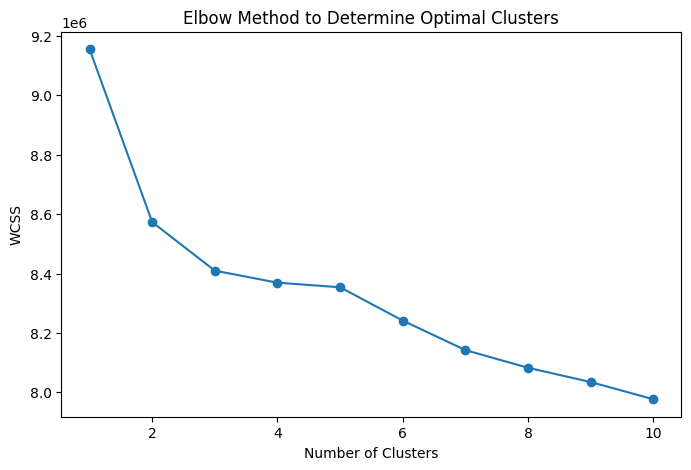

In [104]:
# Elbow method to determine Optimal Clusters

# Initialize an empty list called inertia to store the WCSS for each value of k
inertia = []
#testing for k = 1 to 10
cluster_range = range(1, 11)
# loop to calculate inertia for each k and add to list
for k in cluster_range:
    #Creates a K-Means clustering model with k and random state ensures initialization reproducibility 
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)

# Plot the elbow curve
plt.figure(figsize=(8, 5))
plt.plot(cluster_range, inertia, marker='o')
plt.title('Elbow Method to Determine Optimal Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()

In [57]:
optimal_clusters = 3

# Fit the KMeans model
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
kmeans.fit(X)

# Assign cluster labels generated by the KMeans algorithm to the corresponding users
user_item_matrix['cluster'] = kmeans.labels_

In [103]:
from sklearn.metrics import silhouette_score
labels = kmeans.labels_
# Compute silhouette score
silhouette_avg = silhouette_score(X, labels)
print(f"Silhouette Score for k=3: {silhouette_avg}")

Silhouette Score for k=3: 0.3476601672457918


In [58]:
# Cluster sizes
print(user_item_matrix['cluster'].value_counts())

# Example users in each cluster
for cluster in range(optimal_clusters):
    print(f"Cluster {cluster} users:")
    print(user_item_matrix[user_item_matrix['cluster'] == cluster].index.tolist()[:5])  # Top 5 users

cluster
0    7921
2    1780
1     299
Name: count, dtype: int64
Cluster 0 users:
[1, 2, 3, 4, 5]
Cluster 1 users:
[24, 49, 62, 65, 120]
Cluster 2 users:
[12, 15, 16, 20, 30]


In [138]:
from sklearn.metrics.pairwise import cosine_similarity

# Specify the userId for which you want recommendations
example_user = 12 # Replace with the desired userId

# Ensure that the 'cluster' column exists
user_cluster = user_item_matrix.loc[example_user, 'cluster']

# Get all users in the same cluster
similar_users = user_item_matrix[user_item_matrix['cluster'] == user_cluster]

# Remove 'cluster' column as it's not useful for similarity calculation
similar_users = similar_users.drop(columns='cluster')

# Calculate the cosine similarity between the example_user and all other users in the cluster
user_ratings = user_item_matrix.loc[example_user].drop('cluster')  # Exclude 'cluster' column for similarity calc

# Calculate similarity between example_user and all other users
cosine_similarities = cosine_similarity([user_ratings], similar_users)[0]

# Create a DataFrame to store similarity scores with user ids
similarity_df = pd.DataFrame({
    'userId': similar_users.index,
    'similarity': cosine_similarities
})

# Sort the similar users by similarity score (higher similarity comes first)
similarity_df = similarity_df.sort_values(by='similarity', ascending=False)

# Get the top N most similar users
top_similar_users = similarity_df.head(15)['userId'].values  

# Get the ratings from these top similar users
top_similar_users_ratings = user_item_matrix.loc[top_similar_users]

# Find movies that the example_user hasn't rated
example_user_ratings = user_item_matrix.loc[example_user].drop('cluster')  # Exclude 'cluster' column
unrated_movies = example_user_ratings[example_user_ratings == 0].index

# Get the ratings of unrated movies by the similar users
unrated_movies_ratings = top_similar_users_ratings[unrated_movies]

# Average ratings of the unrated movies by similar users
movie_ratings_average = unrated_movies_ratings.mean(axis=0)

# Sort the movies by the average rating (descending)
recommendations = movie_ratings_average.sort_values(ascending=False).head(10)

In [139]:
# Load the movie metadata CSV and merge with the recommendations
movies_metadata = pd.read_csv('C:/Users/namya_rpahcdl/Documents/movies_metadata.csv', low_memory=False)

recommendations_reset = recommendations.reset_index()
recommendations_reset['movieId'] = recommendations_reset['movieId'].astype(str)
# recommendations['movieId'] = recommendations['movieId'].astype(str)

movies_metadata['id'] = movies_metadata['id'].astype(str)

# # Merge the recommended movie IDs with the movie titles
recommendations_with_titles = recommendations_reset.merge(movies_metadata[['id', 'title']], left_on='movieId', right_on='id', how='left')

# Assuming `user_cluster` contains the cluster info for the example_user
print(f"Recommended movies for user {example_user} (belonging to cluster {user_cluster}):")

# Filter recommendations to exclude rows where title is NaN and select the top 5
filtered_recommendations = recommendations_with_titles[recommendations_with_titles['title'].notna()].head(5)

# Print the filtered recommendations
print(filtered_recommendations[['movieId', 'title']])

Recommended movies for user 12 (belonging to cluster 2):
  movieId                 title
0     111              Scarface
2    1252         Lonely Hearts
3     300  The Science of Sleep
4     110     Three Colors: Red
6    2762    Young and Innocent


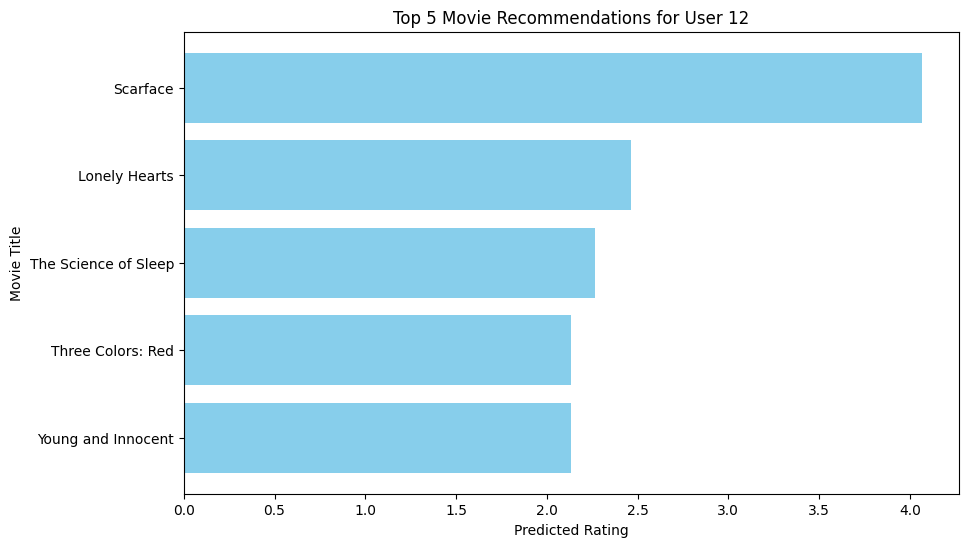

In [140]:
# Plot the top 5 movie recommendations with titles
filtered_recommendations.columns = ['movieId', 'predicted_rating', 'id', 'title']
plt.figure(figsize=(10, 6))
plt.barh(filtered_recommendations['title'], filtered_recommendations['predicted_rating'], color='skyblue')
plt.title(f"Top 5 Movie Recommendations for User {example_user}")
plt.xlabel("Predicted Rating")
plt.ylabel("Movie Title")
plt.gca().invert_yaxis()  # To display the highest-rated movie at the top
plt.show()

In [137]:
print(f"Minimum similarity score: {cosine_similarities.min()}")
print(f"Maximum similarity score: {cosine_similarities.max()}")

Minimum similarity score: 0.0
Maximum similarity score: 0.9999999999999999


In [96]:
print(user_item_matrix)

movieId    1    2    3    4    5    6    7    8    9   10  ...  173941  \
userId                                                     ...           
1        0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...     0.0   
2        0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...     0.0   
3        0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...     0.0   
4        0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...     0.0   
5        0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...     0.0   
...      ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...     ...   
10214    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...     0.0   
10215    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...     0.0   
10217    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...     0.0   
10218    5.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...     0.0   
10219    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...     0.0   

movieId  174053  174055  174725  1755

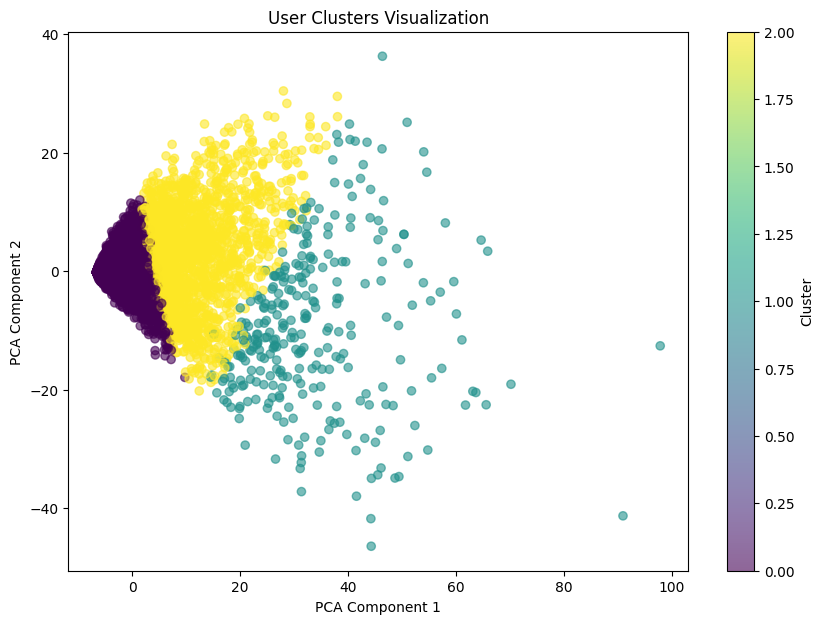

In [97]:
from sklearn.decomposition import PCA

# Exclude 'cluster' column for dimensionality reduction
matrix_without_cluster = user_item_matrix.iloc[:, :-1]

# Reduce to 2 components using PCA
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(matrix_without_cluster)

# Create scatter plot
plt.figure(figsize=(10, 7))
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=user_item_matrix['cluster'], cmap='viridis', alpha=0.6)
plt.colorbar(label='Cluster')
plt.title('User Clusters Visualization')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()


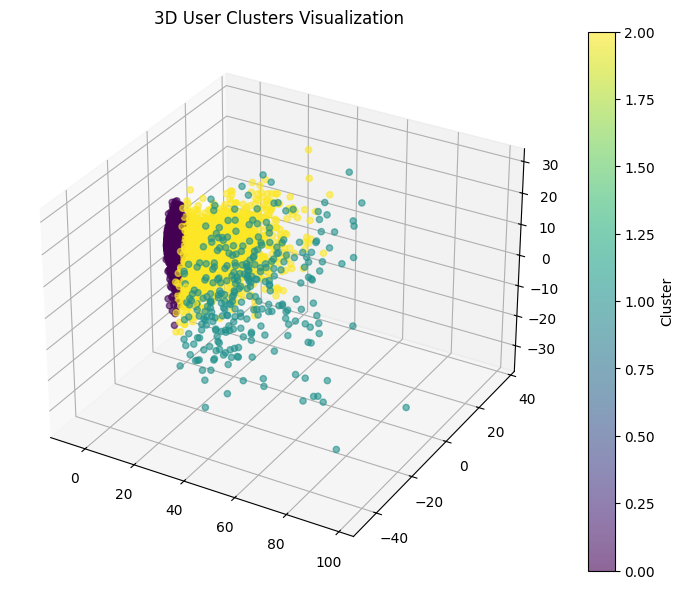

In [98]:
from mpl_toolkits.mplot3d import Axes3D

# Reduce to 3D
pca_3d = PCA(n_components=3)
reduced_data_3d = pca_3d.fit_transform(matrix_without_cluster)

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(reduced_data_3d[:, 0], reduced_data_3d[:, 1], reduced_data_3d[:, 2], 
                      c=user_item_matrix['cluster'], cmap='viridis', alpha=0.6)
plt.colorbar(scatter, label='Cluster')
plt.title('3D User Clusters Visualization')
plt.show()

In [101]:
print(X)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [5. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
